# Topic Tweet classification

Zakaria BEKKAR, CHRIMNI Walid

The goal of the project is to do online tweet classification according to their topic. We will classify english tweets about covid. To do so, we will use a baseline of 30000 tweets to determine the main 15 topics using TF-IDF then we will do online classification of tweets in those 15 topics.

**In order to run this notebook proprely, you should also run the "retrieve_tweets.py" file as well as Kafka.**

# Import 

In [1]:
import gensim.downloader
from wordcloud import WordCloud
from gensim.test.utils import datapath
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from river import cluster, stream, metrics, anomaly
from kafka import KafkaConsumer
import json
import re
import string
import pandas as pd
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from PIL import Image
from IPython.display import clear_output
import pickle
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Walid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Walid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Walid\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


The model for embeddings we will use is a pretrained word2vec model. It is trained on over 400M english tweets.

In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format('D:\word2vec_twitter_model.bin', binary=True, unicode_errors='ignore')

# Functions definition

We define some functions that we will use later on : cleaning tweets, getting embeddings, getting TF-IDF count, ...

In [3]:
tokenizer = RegexpTokenizer(r'\w+')

def get_word2vec_embeddings(model, tokenizer, sentence, k=300):
    if type(sentence) == str:
        sentence = tokenizer.tokenize(sentence)
    vectorized = [model[word] if word in model else np.random.rand(k) for word in sentence]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return(averaged)

def pre_process_tweet(tweet):
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    # tokenize and remove stop words and number
    tweet_tokens = tokenizer.tokenize(tweet)[1:]
    tweet_tokens = [word for word in tweet_tokens if word.isalpha()]
    tweet_tokens = [word for word in tweet_tokens if word.lower() not in ["rt", 'news', 'new']]
    tweet = " ".join([word for word in tweet_tokens if word not in stopwords.words('english')])

    # remove \n from the end after every sentence
    tweet = tweet.strip('\n')

    # Remove any word that starts with the symbol @
    tweet = " ".join(filter(lambda x: x[0] != '@', tweet.split()))

    # remove non utf-8 characters
    tweet = bytes(tweet, 'utf-8').decode('utf-8','ignore')

    # Remove any URL
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"www\S+", "", tweet)

    # remove colons from the end of the sentences (if any) after removing url
    tweet = tweet.strip()
    tweet_len = len(tweet)
    if tweet_len > 0:
        if tweet[len(tweet) - 1] == ':':
            tweet = tweet[:len(tweet) - 1]

    # Remove any hash-tags symbols
    tweet = tweet.replace('#', '')

    # Convert every word to lowercase
    tweet = tweet.lower()

    # remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # trim extra spaces
    tweet = " ".join(tweet.split())

    # lematize words
    tweet = lemmatizer.lemmatize(tweet)

    return(tweet)

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

# Data Analysis

Let's first do some data analysis. We do a word cloud of the tweets we retrieve and we update it every 5 seconds with the new tweets we retrieve.

This enables us to have a first grasp of the main topics.

In [4]:
consumer = KafkaConsumer("covid")

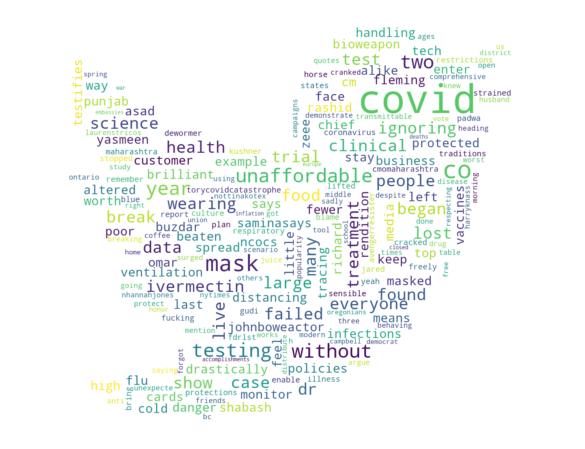

KeyboardInterrupt: 

In [5]:
plt.figure(figsize=(15,8))
twitter_mask = np.array(Image.open("img_notebook/twitter_logo.jpg"))
total_sentences = ""
while True:
    for i in range(10):
        tweet = json.loads(next(iter(consumer)).value)
        clean_tweet = pre_process_tweet(tweet=tweet)
        total_sentences += clean_tweet
        total_sentences += " "
    wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100, mask=twitter_mask, 
    contour_color="steelblue", contour_width=0, background_color="white").generate(total_sentences)

    # plot the graph
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    plt.pause(5)
    clear_output(wait=True)
    plt.figure(figsize=(15,8))


# PCA

Then we do a PCA in 2 and 3 dimensions to see what our data look like. To do so, we retrieve 30000 tweets, it should be enough to represent well our data (it represents tweet on a time window of about 2 hours).

In [ ]:
consumer = KafkaConsumer('covid')

We recover the tweets and their embeddings and save them.

In [ ]:
# n_sample = 30000
# tweets_for_pca = np.zeros((n_sample, 400))
# text_data = []
# row = 0

# for tweet in consumer:
#     if row == n_sample:
#         break
#     tweet = json.loads(tweet.value)
#     clean_tweet = pre_process_tweet(tweet)
#     embeddings = get_word2vec_embeddings(model=model, tokenizer=tokenizer, sentence=clean_tweet, k=400)
#     if np.isnan(embeddings).sum() == 0:
#         tweets_for_pca[row,:] = embeddings
#         text_data.append(clean_tweet)
#         row += 1

As we have saved them (hidden cell), we can load them with the following cell.

In [6]:
with open('tweets_for_pca', 'rb') as f:
    tweets_for_pca = pickle.load(f)

with open('text_data', 'rb') as f:
    text_data = pickle.load(f)


## 2D PCA

We begin by the 2D PCA.

In [7]:
pca = PCA(n_components=2)
pca.fit(tweets_for_pca)
pca_data = pd.DataFrame(pca.transform(tweets_for_pca),columns=['FirstComponent','SecondComponent'])
pca_data.head()

FirstComponent  SecondComponent
0        0.939473        -0.010121
1        0.733613         0.231345
2       -0.718002        -0.404853
3       -1.051107         0.073674
4        2.074784        -0.268961

<AxesSubplot:xlabel='FirstComponent', ylabel='SecondComponent'>

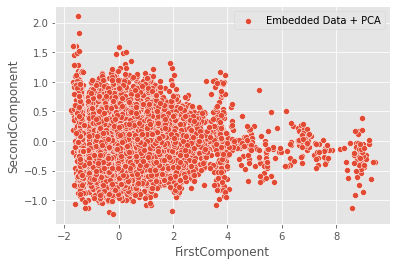

In [8]:
sns.scatterplot(x=pca_data.FirstComponent,y=pca_data.SecondComponent,label='Embedded Data + PCA')

## 3D PCA

Then we do PCA in 3 dimensions.

In [9]:
pca = PCA(n_components=3)
pca.fit(tweets_for_pca)
pca_data = pd.DataFrame(pca.transform(tweets_for_pca),columns=['FirstComponent','SecondComponent','ThirdComponent'])
x = pca_data.FirstComponent
y = pca_data.SecondComponent
z = pca_data.ThirdComponent

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=3,
        color='navy',                
        opacity=0.8
    )
)])


fig.show()

With this interactive plot, we can see a bit better what our data looks like.

# Topic classification

Let's now dive in the topic classification. As we are not yet doing online classification, we will use MiniBatchKMeans from sklearn. It allows us to do batch learning now and online learning later on with the `partial_fit` method.

Then, we use use TF-IDF to understand which words appears the most (we exclud stop words as they compares too much). TF-IDF counts in a smart way how many times each word appears inside of a class of documents. If the word appears in all the other classes too, it is probably not influent (like “the” or “an”) and, for this reason, it is not considered to be “frequent”. This allows us to recover the real topics.

As previously, once we have created and trained the model once, we can either load it or create a new model. We choose here to load the model.

In [10]:
n_clusters=15
# cluster = MiniBatchKMeans(n_clusters=n_clusters, random_state=0).fit(tweets_for_pca)
with open('cluster', 'rb') as f:
    cluster = pickle.load(f)
cluster.fit(tweets_for_pca)

MiniBatchKMeans(n_clusters=15, random_state=0)

For each cluster, we regroup all the document in one big document to be able to do TF-IDF count.
Then, for each class, retrieve the top n words with the highest TF-IDF score, and then, for each class, choose the word with the lowest score. This method enables us to recover the words that appears often in a document but at the same time are discriminating.

In [11]:
docs_df = pd.DataFrame(text_data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(text_data))
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

Topic  Size
0       0  8217
10     10  5329
13     13  2824
12     12  2763
9       9  2200
3       3  2178
2       2  2087
6       6  2005
7       7   845
1       1   524

In [12]:
data = pd.DataFrame(top_n_words[0][:n_clusters])
data['Class'] = [0]*len(data)
for i in range(1,len(top_n_words)):
  data_i = data_0 = pd.DataFrame(top_n_words[i][:1000])
  data_i['Class'] = [i]*len(data_i)
  data = data.append(data_i)
data = data.sort_values(by=1,ascending=False)

final_data = data.drop_duplicates(subset=0).sort_values(by='Class').drop_duplicates(subset='Class',keep='last')
final_data

0         1  Class
4         years  0.013299      0
2        sacked  0.061503      1
9          feel  0.018014      2
3           nhs  0.021411      3
4          doug  0.541858      4
6    ivermectin  0.469384      5
8  bennyjohnson  0.018433      6
1   myocarditis  0.192534      7
5       ordered  0.502942      8
5        deaths  0.017067      9
3          mask  0.019129     10
7       skynews  0.211171     11
3        nausea  0.077289     12
8      vaccines  0.023123     13
9      footpath  0.000000     14

Now we have the label of each class. We create a dictionnary which associate the name of the label with the number of the cluster.

In [13]:
labels_to_class = {i: final_data[final_data.Class == i][0].values[0] for i in range(n_clusters)}
labels_to_class

{0: 'years',
 1: 'sacked',
 2: 'feel',
 3: 'nhs',
 4: 'doug',
 5: 'ivermectin',
 6: 'bennyjohnson',
 7: 'myocarditis',
 8: 'ordered',
 9: 'deaths',
 10: 'mask',
 11: 'skynews',
 12: 'nausea',
 13: 'vaccines',
 14: 'footpath'}

Let's see what our data looks like when we give a color to each label.

First in 2D.

<AxesSubplot:xlabel='FirstComponent', ylabel='SecondComponent'>

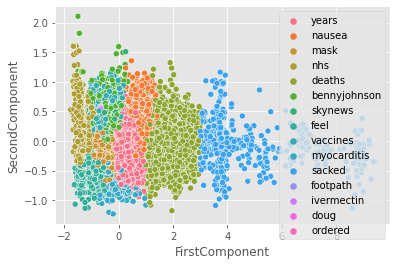

In [14]:
pca_2d = PCA(n_components=2)
pca_2d.fit(tweets_for_pca)
pca_2d_data = pd.DataFrame(pca_2d.transform(tweets_for_pca),columns=['FirstComponent','SecondComponent'])
sns.scatterplot(x=pca_2d_data.FirstComponent,y=pca_2d_data.SecondComponent, 
                hue=[labels_to_class[cluster_label] for cluster_label in cluster.labels_])

Then in 3D.

In [15]:
pca_3d = PCA(n_components=3)
pca_3d.fit(tweets_for_pca)
pca_3d_data = pd.DataFrame(pca_3d.transform(tweets_for_pca),columns=['FirstComponent','SecondComponent','ThirdComponent'])
x = pca_3d_data.FirstComponent
y = pca_3d_data.SecondComponent
z = pca_3d_data.ThirdComponent


In [16]:
df_3D = pd.DataFrame(columns=['x', 'y', 'z', 'label'])
df_3D['x'] = x
df_3D['y'] = y
df_3D['z'] = z
df_3D['label'] = [labels_to_class[cluster_label] for cluster_label in cluster.labels_]

In [17]:
fig = px.scatter_3d(df_3D, x='x', y='y', z='z',
              color='label')

fig.show()

Those 2 plots shows us that our data is well separeted, we can see that each class occupies a place of the space, and that is just in lower dimension, we can only imagine how it is in 400 dimensions. 

# Online topic classification

Now we are able to do online topic classification. We will use the cluster we have determined in the last section, as well as the same MiniBatchKMeans.
Everytime a tweet is classified, we will put it in a DataFrame that contains the tweets and their prediction.
Every 100 tweets, we will save this DataFrame as well as save our model.

In [18]:
consumer = KafkaConsumer('covid')

In [19]:
with open('cluster', 'rb') as f:
    cluster = pickle.load(f)

In [20]:
df_predictions = pd.DataFrame(columns=['tweet', 'prediction'])

In [21]:
for tweet in consumer:
    row = df_predictions.shape[0]
    tweet = json.loads(tweet.value)
    clean_tweet = pre_process_tweet(tweet)
    embeddings = get_word2vec_embeddings(model=model, tokenizer=tokenizer, sentence=clean_tweet, k=400).reshape(1,-1).astype(np.double)
    cluster.partial_fit(embeddings)
    prediction = cluster.predict(embeddings)[0]
    df_predictions.loc[row, 'tweet'], df_predictions.loc[row, 'prediction'] = tweet, labels_to_class[prediction]
    if row % 100 == 0:
        print(f'{row} tweets have been classified')
        print(100*'-')
        with open('cluster', 'wb') as f:
            pickle.dump(cluster, f)
        try:
            df_predictions.to_excel('df_predictions.xls')
        except:
            pass


0 tweets have been classified
----------------------------------------------------------------------------------------------------
100 tweets have been classified
----------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [22]:
df_predictions

tweet prediction
0    A federal program that reimburses providers ha...   vaccines
1    RT @SaminaSays: Shabash for the health cards i...     deaths
2    RT @Jim_Jordan: Almost $250 billion in #COVID ...       mask
3    RT @TheChefsGardens: Do you think Biden suppor...      years
4    RT @poorcanuck: 41,834 DEAD 3.9 Million Injure...   vaccines
..                                                 ...        ...
123  RT @SaminaSays: Shabash for the health cards i...     deaths
124  Got my second Moderna  Covid booster shot yest...      years
125  RT @nhannahjones: A study to demonstrate what ...       mask
126  Ivermectin Does Not Reduce Risk of Covid Hospi...   vaccines
127  RT @JujuliaGrace: COVID is everywhere. Wear ma...     deaths

[128 rows x 2 columns]